In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.chdir("../..")


In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import json
import xsim
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm


In [4]:
from qml.db import dpo as xdpo
from qml.db import target as xtarget
from qml.db.ml import MLDatasetGenerator
from qml.model.gate import Gateset
from qml.model.unit import UnitManager, Unit
from qml.model.encoding import EncodingUnitManager
from qml.model.model import Model
from qml.optimizer import dpo as xdpopt
from qml.optimizer import evaluator as xeval
from qml.tools.random import XRandomGenerator
from qml.tools.sampler import CandidateSampler
from qml import optimizer as xoptim


## Config

In [28]:
# circuit
num_qubits = 2
num_gates = 3

# dpo dataset
db_filename = "dpo_databsae.txt"
batch_size = 10
dim_wavelet = 4
wavelet = xeval.Haar()

## validation
validation_db_size = 10
dim_order = 4

# qml
num_train_step = 2
dim_input = 1
dim_output = 1
shots = 50

# ocg
num_round = 3

# model
dim_hiddens = [32, 32]

# training
lr = 1e-3
max_epoch = 1000
cpo = True


## Data

### QML training dataset

In [29]:
dataset = xdpo.DPODataset(db_filename, num_qubits, dim_wavelet)
loader = xdpo.DPODataLoader(dataset, num_qubits, 1, dim_wavelet)


### Validation dataset

In [30]:
tfun = xtarget.PolynominalTargetFunctionGenerator(dim_order)
tgen = MLDatasetGenerator(tfun)
validation_datasets = [
    tgen.generate(validation_db_size)
    for _ in range(5)
]


## Model preparation

In [31]:
policy = xdpopt.Policy(dim_wavelet, num_qubits, num_gates, dim_hiddens)
reference = xdpopt.Policy(dim_wavelet, num_qubits, num_gates, dim_hiddens)
reference.load_state_dict(policy.state_dict())

<All keys matched successfully>

In [32]:
sampler = CandidateSampler(policy)

### base qc preparation

In [26]:
def get_base_qc(num_qubits, dim_input):
    return Model(
        num_qubits, dim_output,
        EncodingUnitManager.AngleEncoding(dim_input, num_qubits, repeat=True),
        [], [], shots=shots
    )

## Training

### Before training evaluation avec validation dataset

In [27]:
def ax():
    return plt.gca()


In [16]:
def validate(sampler, datasets, num_qubits, num_rounds, num_train_steps):

    losses = []
    
    for dataset in tqdm(datasets):
        model = get_base_qc(num_qubits, dataset.dim_output)
        veval = xeval.WaveletEvaluator(wavelet, dataset, wavelet_dim=dim_wavelet)

        losses_vdb = []

        for round in range(1, num_rounds+1):
            # 1. measure the wavelet series
            vresult = veval(model.trainable_parameters, model)

            # 2. estimate the candidate unit
            wseries = vresult.powers
            candidate = sampler.sample(wseries)
            
            # 3. update the trainable unit
            model.fix_trainable_units()
            model = Model(
                model.nq, model.nc,
                model.input_units,
                model.fixed_units,
                candidate,
                shots=model.shots,
            )

            # 4. train the model
            optimizer = xoptim.LocalSearchOptimizer(dataset)
            tresult = optimizer.optimize(model, num_train_steps, verbose=False)

            # 5. update the model parameters
            model.update_parameters(tresult.first.x)

            # logging
            losses_vdb.append(vresult.mse)
        losses.append(losses_vdb)

    losses.shape
# plt.plot(losses)
# plt.show()
    

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:02<00:00, 12.58s/it]


AttributeError: 'list' object has no attribute 'shape'

In [18]:
losses = np.vstack(losses)

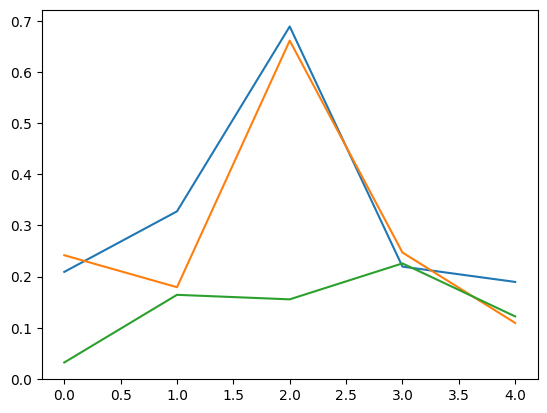

In [20]:
plt.plot(losses)